In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import clip
import random

In [2]:
# ── Hyperparameters ─────────────────────────────────────────────────────────────
batch_size    = 128       # training batch size
epochs        = 5       # number of epochs
lr            = 2e-5      # learning rate
weight_decay  = 1e-4      # weight decay for AdamW
noise_prob    = 0.25       # probability [0–1] to corrupt each label
dropout_rate  = 0.1       # MC-Dropout probability
device        = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# ───────────────────────────────────────────────────────────────────────────────

cuda


In [3]:
def corrupt_labels(labels: torch.Tensor, num_classes: int, noise_prob: float) -> torch.Tensor:
    """
    With probability noise_prob, replace each label with a random class.
    """
    if noise_prob <= 0:
        return labels
    mask = torch.rand(labels.shape, device=labels.device) < noise_prob
    random_labels = torch.randint(num_classes, labels.shape, device=labels.device)
    return torch.where(mask, random_labels, labels)

In [4]:
# ── 1) Load CLIP and extract vision tower ────────────────────────────────────────
model, _    = clip.load("ViT-B/32", device=device)
model = model.float().to(device)
vision      = model.visual
embed_dim   = vision.output_dim   # typically 512
num_classes = 10

# 2) Classification head + MC-Dropout
classifier = nn.Linear(embed_dim, num_classes).to(device)
dropout    = nn.Dropout(p=dropout_rate).to(device)

# 3) Data transforms
normalize = transforms.Normalize(
    mean=(0.48145466, 0.4578275, 0.40821073),
    std=(0.26862954, 0.26130258, 0.27577711)
)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# 4) Datasets & loaders
train_ds      = torchvision.datasets.CIFAR10("data", train=True,  download=True, transform=train_transform)
test_ds       = torchvision.datasets.CIFAR10("data", train=False, download=True, transform=test_transform)
train_loader  = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
test_loader   = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# 6) Optimizer & loss
params    = list(vision.parameters()) + list(classifier.parameters())
optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# ── 7) Training loop ─────────────────────────────────────────────────────────────
for epoch in range(1, epochs + 1):
    vision.train(); classifier.train(); dropout.train()
    running_loss = 0.0
    correct = total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # a) corrupt labels
        noisy_labels = corrupt_labels(labels, num_classes, noise_prob)

        optimizer.zero_grad()
        # b) forward with dropout
        feats  = vision(imgs)          # [B, embed_dim]
        feats  = dropout(feats)        # MC-Dropout
        logits = classifier(feats)     # [B, num_classes]
        loss   = criterion(logits, noisy_labels)
        loss.backward()
        optimizer.step()

        # c) accumulate stats (true-label accuracy)
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    # 8) Evaluation (clean test set)
    vision.eval(); classifier.eval(); dropout.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats  = vision(imgs)
            feats  = dropout(feats)    # deterministic if dropout.eval()
            logits = classifier(feats)
            preds  = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    test_acc = correct / total

    print(f"Epoch {epoch:2d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Test Acc: {test_acc:.3f}")
torch.save(model.state_dict(), "clip_cifar10_contaminated.pth")

Epoch  1 | Train Loss: 1.1802 | Train Acc: 0.911 | Test Acc: 0.935
Epoch  2 | Train Loss: 1.1124 | Train Acc: 0.952 | Test Acc: 0.948
Epoch  3 | Train Loss: 1.1113 | Train Acc: 0.962 | Test Acc: 0.944
Epoch  4 | Train Loss: 1.0873 | Train Acc: 0.968 | Test Acc: 0.947
Epoch  5 | Train Loss: 1.0866 | Train Acc: 0.972 | Test Acc: 0.946


In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ── Settings ───────────────────────────────────────────────────────────────────
mc_samples = 30    # number of stochastic forward passes
num_bins   = 10    # for calibration bins
num_classes = 10   # CIFAR-10
# ───────────────────────────────────────────────────────────────────────────────

# ── 1) Collect confidences & correctness via MC-Dropout ─────────────────────────
all_confidences = []
all_correct     = []

vision.eval()
classifier.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        B = images.size(0)

        # store probabilities for each MC sample
        probs_mc = torch.zeros((mc_samples, B, num_classes), device=device)

        for m in range(mc_samples):
            dropout.train()  # enable dropout during inference
            feats = vision(images)
            feats = dropout(feats)
            logits = classifier(feats)
            probs_mc[m] = F.softmax(logits, dim=1)

        # compute mean probability per sample
        mean_probs = probs_mc.mean(dim=0)  # [B, num_classes]
        confidences, preds = mean_probs.max(dim=1)

        all_confidences.extend(confidences.cpu().numpy())
        all_correct.extend((preds == labels).cpu().numpy())

confidences = np.array(all_confidences)
correctness = np.array(all_correct)

# ── 2) Compute calibration (reliability) ────────────────────────────────────────
bins        = np.linspace(0.0, 1.0, num_bins + 1)
bin_lowers  = bins[:-1]
bin_uppers  = bins[1:]
acc_bin     = np.zeros(num_bins)
conf_bin    = np.zeros(num_bins)
ece         = 0.0

for i, (low, high) in enumerate(zip(bin_lowers, bin_uppers)):
    mask = (confidences > low) & (confidences <= high)
    if mask.any():
        acc     = correctness[mask].mean()
        conf    = confidences[mask].mean()
        acc_bin[i]  = acc
        conf_bin[i] = conf
        ece += np.abs(conf - acc) * mask.mean()

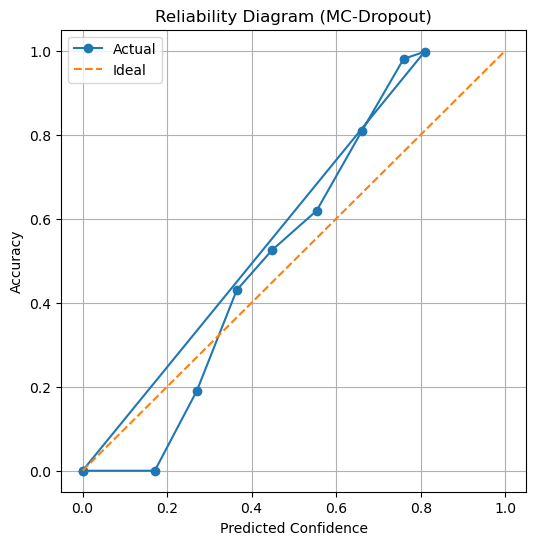

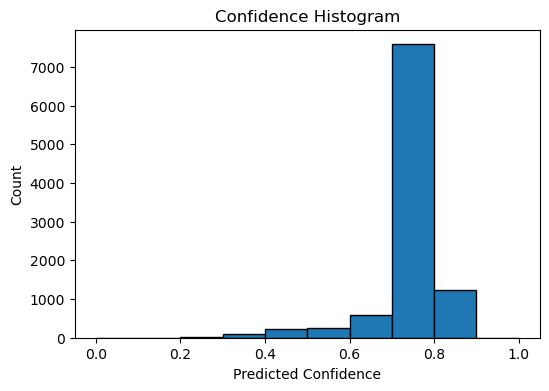

Expected Calibration Error (ECE): 0.2038


In [7]:
# ── 3) Reliability Diagram ─────────────────────────────────────────────────────
plt.figure(figsize=(6,6))
plt.plot(conf_bin, acc_bin, marker='o', label='Actual')
plt.plot([0,1], [0,1], linestyle='--', label='Ideal')
plt.xlabel('Predicted Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram (MC-Dropout)')
plt.legend()
plt.grid(True)
plt.show()

# ── 4) Confidence Histogram ────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.hist(confidences, bins=bins, edgecolor='black')
plt.xlabel('Predicted Confidence')
plt.ylabel('Count')
plt.title('Confidence Histogram')
plt.show()

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Accuracy: 0.9461
Mean Brier Score: 0.1309
Mean NLL: 0.3947


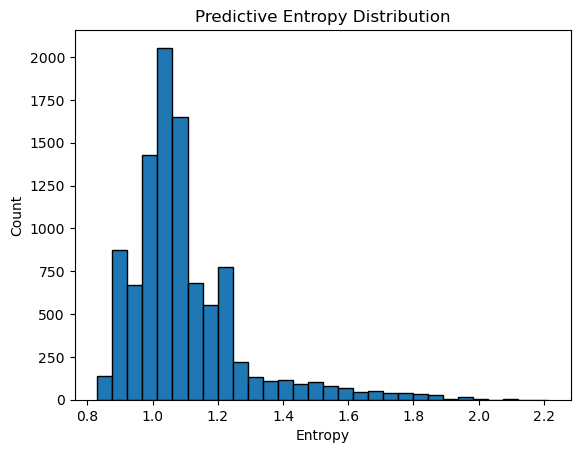

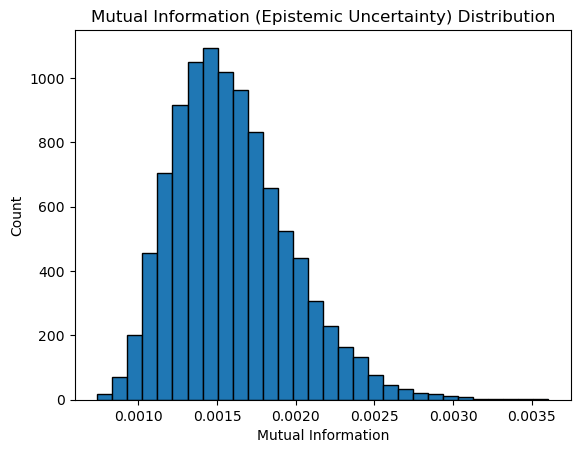

/tmp/ipykernel_3463571/1740295385.py:91: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([entropies_all[correct_all], entropies_all[~correct_all]], labels=['Correct', 'Incorrect'])
/tmp/ipykernel_3463571/1740295385.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mis_all[correct_all], mis_all[~correct_all]], labels=['Correct', 'Incorrect'])


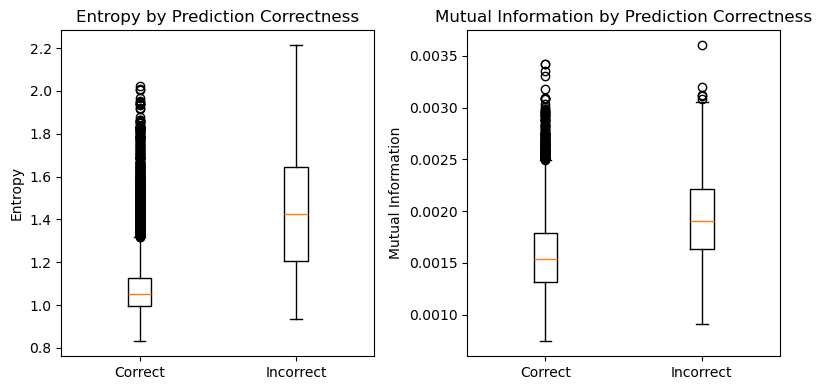

In [8]:
# Assumes: vision, classifier, dropout, test_loader, device, mc_samples, num_classes are defined
# mc_samples = 30, num_bins = 10 from previous context

# 1) Collect per-sample statistics via MC-Dropout
all_mean_probs = []
all_labels     = []
all_entropies  = []
all_mis        = []
all_briers     = []
all_nlls       = []

vision.eval()
classifier.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        B = images.size(0)
        # store MC probabilities
        probs_mc = torch.zeros((mc_samples, B, num_classes), device=device)
        for m in range(mc_samples):
            dropout.train()  # enable dropout at inference
            feats = vision(images)
            feats = dropout(feats)
            logits = classifier(feats)
            probs_mc[m] = F.softmax(logits, dim=1)
        # compute mean predictive distribution
        mean_probs = probs_mc.mean(dim=0)  # [B, C]
        # move to CPU numpy
        mean_np = mean_probs.cpu().numpy()
        labels_np = labels.cpu().numpy()
        # one-hot encoding
        onehot = np.eye(num_classes)[labels_np]
        # multiclass Brier score per sample: sum (p_i - y_i)^2
        brier = np.sum((mean_np - onehot) ** 2, axis=1)
        # negative log-likelihood per sample
        nll = -np.log(mean_np[np.arange(B), labels_np] + 1e-12)
        # predictive entropy per sample
        entropy = -np.sum(mean_np * np.log(mean_np + 1e-12), axis=1)
        # expected entropy (aleatoric) per sample
        ent_mc = -np.sum(probs_mc.cpu().numpy() * np.log(probs_mc.cpu().numpy() + 1e-12), axis=2)
        exp_entropy = ent_mc.mean(axis=0)
        # mutual information per sample (epistemic)
        mi = entropy - exp_entropy

        # collect
        all_mean_probs.append(mean_np)
        all_labels.append(labels_np)
        all_entropies.append(entropy)
        all_mis.append(mi)
        all_briers.append(brier)
        all_nlls.append(nll)

# concatenate
mean_probs_all = np.concatenate(all_mean_probs)
labels_all     = np.concatenate(all_labels)
entropies_all  = np.concatenate(all_entropies)
mis_all        = np.concatenate(all_mis)
brier_all      = np.concatenate(all_briers)
nll_all        = np.concatenate(all_nlls)

# compute overall metrics
preds_all     = np.argmax(mean_probs_all, axis=1)
correct_all   = preds_all == labels_all
accuracy      = correct_all.mean()
brier_score   = brier_all.mean()
nll_score     = nll_all.mean()

print(f"Accuracy: {accuracy:.4f}")
print(f"Mean Brier Score: {brier_score:.4f}")
print(f"Mean NLL: {nll_score:.4f}")

# 2) Plot Distribution of Uncertainty Metrics
plt.figure()
plt.hist(entropies_all, bins=30, edgecolor='black')
plt.title('Predictive Entropy Distribution')
plt.xlabel('Entropy')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(mis_all, bins=30, edgecolor='black')
plt.title('Mutual Information (Epistemic Uncertainty) Distribution')
plt.xlabel('Mutual Information')
plt.ylabel('Count')
plt.show()

# 3) Boxplots: Entropy & MI by correctness
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.boxplot([entropies_all[correct_all], entropies_all[~correct_all]], labels=['Correct', 'Incorrect'])
plt.title('Entropy by Prediction Correctness')
plt.ylabel('Entropy')

plt.subplot(1, 2, 2)
plt.boxplot([mis_all[correct_all], mis_all[~correct_all]], labels=['Correct', 'Incorrect'])
plt.title('Mutual Information by Prediction Correctness')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()

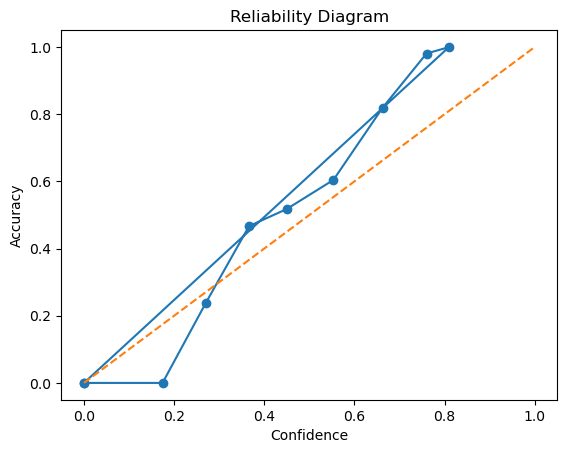

Expected Calibration Error (ECE): 0.2038


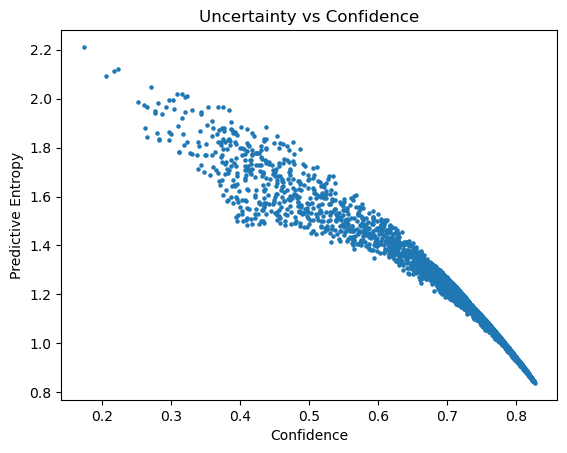

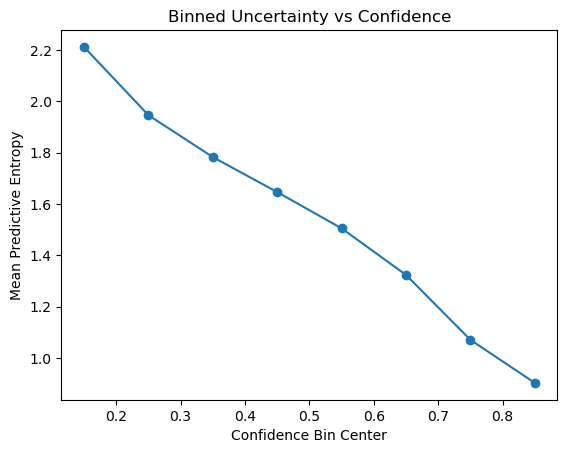

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Assumes vision, classifier, dropout, test_loader, device, mc_samples, num_classes are defined

# 1) Gather MC-dropout predictions: confidences, entropies, correctness
all_confidences = []
all_entropies   = []
all_correct     = []

vision.eval()
classifier.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        B = images.size(0)
        probs_mc = torch.zeros((mc_samples, B, num_classes), device=device)
        for _ in range(mc_samples):
            dropout.train()  # enable dropout at inference
            feats = vision(images)
            feats = dropout(feats)
            logits = classifier(feats)
            probs_mc[_] = F.softmax(logits, dim=1)
        mean_probs = probs_mc.mean(dim=0)          # [B, C]
        confidences, preds = mean_probs.max(dim=1) # top-1 confidence & pred
        # predictive entropy
        ent = - (mean_probs * (mean_probs + 1e-12).log()).sum(dim=1)
        
        all_confidences.extend(confidences.cpu().numpy())
        all_entropies.extend(ent.cpu().numpy())
        all_correct.extend((preds == labels).cpu().numpy())

confidences = np.array(all_confidences)
entropies   = np.array(all_entropies)
correctness = np.array(all_correct)

# 2) Calibration / Reliability Curve
num_bins = 10
bins = np.linspace(0.0, 1.0, num_bins+1)
bin_lowers = bins[:-1]
bin_uppers = bins[1:]
acc_bin = np.zeros(num_bins)
conf_bin = np.zeros(num_bins)
ece = 0.0

for i, (low, high) in enumerate(zip(bin_lowers, bin_uppers)):
    mask = (confidences > low) & (confidences <= high)
    if mask.any():
        acc = correctness[mask].mean()
        conf = confidences[mask].mean()
        acc_bin[i] = acc
        conf_bin[i] = conf
        ece += np.abs(conf - acc) * mask.mean()

# Plot Reliability Diagram
plt.figure()
plt.plot(conf_bin, acc_bin, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.show()

print(f"Expected Calibration Error (ECE): {ece:.4f}")

# 3) Uncertainty vs Confidence Scatter
plt.figure()
plt.scatter(confidences, entropies, s=5)
plt.xlabel('Confidence')
plt.ylabel('Predictive Entropy')
plt.title('Uncertainty vs Confidence')
plt.show()

# 4) Binned mean entropy vs confidence
mean_entropy_per_bin = []
bin_centers = (bin_lowers + bin_uppers) / 2
for low, high in zip(bin_lowers, bin_uppers):
    mask = (confidences > low) & (confidences <= high)
    if mask.any():
        mean_entropy_per_bin.append(entropies[mask].mean())
    else:
        mean_entropy_per_bin.append(np.nan)

plt.figure()
plt.plot(bin_centers, mean_entropy_per_bin, marker='o')
plt.xlabel('Confidence Bin Center')
plt.ylabel('Mean Predictive Entropy')
plt.title('Binned Uncertainty vs Confidence')
plt.show()
